In [9]:
#-----------------------------------------------------------------------------------------------
#
# ------------- Forecasted Decadal Reductions in Groundwater Pumping at J17---------------------
# ----------------------------------------------------------------------------------------------
# -----------Using Tiered Critical Management Plan (CMP) and MACA data -------------------------
#-----------------------------------------------------------------------------------------------
#
#-----------------------------------------------------------------------------------------------
#--- import libraries and packages
#-----------------------------------------------------------------------------------------------

import pandas as pd
import numpy as np
import math
from wdmtoolbox import wdmtoolbox 
import matplotlib.pyplot as plt

%matplotlib inline 

from datetime import datetime   
from dateutil import relativedelta

import numpy.polynomial.polynomial as poly

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from datetime import datetime, timedelta

from functools import reduce

from PIL import Image

from itertools import islice

import csv

import matplotlib.dates as mdates

from pandas import ExcelWriter
from pandas import ExcelFile


import os
from matplotlib import rc
import matplotlib.ticker as mtick         

# center all the figures and tables throughout the report
from IPython.display import display, HTML
display(HTML("""<style>.output {
    display: flex;
    align-items: center;
    text-align: center;}</style> """))

print (' All libraries, tools, and functions have been succesfully uploaded  ')

 All libraries, tools, and functions have been succesfully uploaded  


In [10]:
os.getcwd()

'/home/c0d3b23ak32/Desktop/XAI/Springs/Comal'

In [11]:
#-------------------------------------------------------------------------------------------------------
# 
#-------------------------------------------------------------------------------------------------------
base_dir = os.getcwd()
base_folder = "/Catboost_untuned/RCP85"


df_SpringFlow_original  = pd.read_excel(base_dir+base_folder+"/df_future.xlsx",engine = "openpyxl")
df_SpringFlow_original  = df_SpringFlow_original.rename(columns = {'Unnamed: 0' : 'Date'})
df_SpringFlow_original = df_SpringFlow_original[['Date', 'SF$[m^3/s]$']]
df_SpringFlow_original = df_SpringFlow_original.rename(columns={'SF$[m^3/s]$':'SF$[m^3/s]$'})
df_SpringFlow_data = df_SpringFlow_original

In [12]:
#-------------------------------------------------------------------------------------------------------
# remove the data before 12/31/2019 
#-------------------------------------------------------------------------------------------------------

condition_to_slice     = (df_SpringFlow_data.Date > '2019-12-31') 
df_SpringFlow_data_reduced = []
df_SpringFlow_data_reduced = df_SpringFlow_data[condition_to_slice]
df_SpringFlow_data_reduced.reset_index(drop=True, inplace=True)
#df_SpringFlow_data_reduced


In [13]:
#-----------------------------------------------------------------------------------------------------------
# start and end dates
#------------------------------------------------------------------------------------------------------------

time_start = str( df_SpringFlow_data_reduced.Date.iloc[0].floor('d')  ).rstrip(' 00:00:00')
time_end   = str( df_SpringFlow_data_reduced.Date.iloc[-1].floor('d') ).rstrip(' 00:00:00')

print('SpringFlow data at J17 starts on :', time_start)
print('SpringFlow data at J17 ends on :', time_end)


SpringFlow data at J17 starts on : 2020-01-05
SpringFlow data at J17 ends on : 2099-12-27


In [14]:
#-------------------------------------------------------------------------------------------------------
# numeric values of GWL data
#-------------------------------------------------------------------------------------------------------
df_numeric_values_J17 = pd.to_numeric(df_SpringFlow_data_reduced['SF$[m^3/s]$' ], errors='coerce')
df_numeric_values_J17

df_SpringFlow = df_numeric_values_J17.to_frame()
df_SpringFlow

df_SpringFlow['Date'] = df_SpringFlow_data_reduced.Date
df_SpringFlow

cols = list(df_SpringFlow.columns)
cols.insert(0, cols.pop(cols.index('Date')))
df_SpringFlow = df_SpringFlow.loc[:, cols]
#df_SpringFlow
#plt.plot(df_SpringFlow)

In [15]:
#--------------------------------------------------------------------------------------------------------------------
# ----  basic statistics
#--------------------------------------------------------------------------------------------------------------------

def simple_stat(df_data):
    print('Number of measurements :   ', len(df_data),'\n')     
    minval = df_data.min()
    maxval = df_data.max()
    typical_vals = maxval
    df_stat = pd.concat([minval, maxval, typical_vals], axis = 1)
    df_stat = df_stat.rename(columns={0 : 'Min', 1 : 'Max',  2 : 'Reference'})
    df_stat.loc[df_stat['Reference'] == maxval[0],  'Reference']  =  ' '
    df_stat.loc[df_stat['Reference'] == maxval[1],  'Reference']  =  '150-250 m'
    return df_stat

In [16]:
#---------------------------------------------------------------------------------------
# Data Quality Check -- basic statistics 
#---------------------------------------------------------------------------------------

simple_stat = simple_stat(df_SpringFlow)
simple_stat.style.set_properties(**{'width': '200px'})
display(simple_stat)

Number of measurements :    4174 



,Min,Max,Reference
Date,2020-01-05 00:00:00,2099-12-27 00:00:00,
SF$[m^3/s]$,1.25412,12.1904,150-250 m


In [17]:
#---------------------------------------------------------------------------------------
# calculate number of missing J17 gw data 
#---------------------------------------------------------------------------------------

data_len = len(df_SpringFlow)
print('Data length             :', data_len)

data_non_null = df_SpringFlow['SF$[m^3/s]$'].count()
miss_data     = data_len - data_non_null
print('Number missing data     :', miss_data)

percent_missing_data = df_SpringFlow['SF$[m^3/s]$'].count()
print('% missing data          :', round ( (100 * miss_data / data_len), 1) )

per_miss_data = 100 * miss_data / data_len
per_miss_data

Data length             : 4174
Number missing data     : 0
% missing data          : 0.0


0.0

In [18]:
if per_miss_data > 1.0 :  # if <1% data is missing
    #---------------------------------------------------------------------------------------
    # impute missing data by linear interpolation - temp solution
    #---------------------------------------------------------------------------------------
    print('linear interpolation is implemented')
    df_SpringFlow['SF$[m^3/s]$'].interpolate(method = 'linear', limit_direction = 'both', inplace =True)
    data_non_null = df_SpringFlow['SF$[m^3/s]$'].count()
    data_non_null

In [19]:
#----------------------------------------------------------------------------------------------------------------------
# plot data - basic
#----------------------------------------------------------------------------------------------------------------------
def plot_basic(Station, df, data, fnt_size, y_ax_label, ymin, ymax, data_label):
    fig = plt.figure()
    fig      = plt.figure(figsize=(20,28))
    ax = fig.add_subplot(4,2,1)
    ax.plot(df.Date, df[data],'-', color = 'red', lw = 1.5, mfc= 'None', markersize=13, label = data_label)

    #ax.grid()
    ax.grid(True, which='major', axis='x' )
    ax.grid(True, which='major', axis='y' )
    ax.set_xlabel('Date', fontsize = fnt_size)
    ax.tick_params(axis = "x", labelsize = fnt_size)
    ax.xaxis.set_tick_params(pad=5)
    #ax.xaxis.set_major_locator(mdates.YearLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))
    ax.set_ylabel(y_ax_label, fontsize = fnt_size), ax.set_ylim([ymin, ymax])
    ax.tick_params(axis = "y", labelsize = fnt_size)
    ax.yaxis.set_tick_params(pad=5) 
    plt.xticks(rotation = 30)
    yoffset=0.05                    
    ax.set_title(Station, fontsize = fnt_size)
    shiftx_annot =  0
    shifty_annot = 0.40        
    plt.show()

<Figure size 432x288 with 0 Axes>

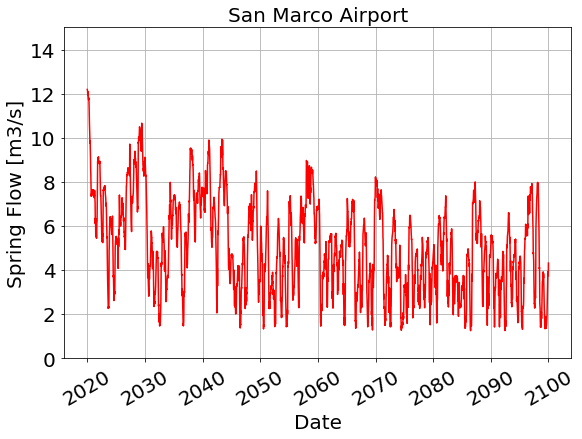

In [20]:
#----------------------------------------------------------------------------------------------------------------------
# plot groundwater elevation at J-17
#----------------------------------------------------------------------------------------------------------------------
fnt_size    = 20
leg_loc     = 2
Station     = 'San Marco Airport'
label       = 'Spring Flow'
y_ax_label  =  "Spring Flow [m3/s]"
y_min       = 0
y_max       = 15 

plot_basic(Station, df_SpringFlow, 'SF$[m^3/s]$', fnt_size, y_ax_label, y_min, y_max, label)

In [21]:
#----------------------------------------------------------------------------------------------------------------------
# plot data with critical stage requirement
#----------------------------------------------------------------------------------------------------------------------

def plot_with_critical_stage(Station, df, data, fnt_size, y_ax_label, ymin, ymax, data_label,num_of_cs, cs_1, \
                             cs_2, cs_3, cs_4, cs_5, cs_line_th, leg_loc, CS_level_loc_x):
    # cs -> critical stage
    fig = plt.figure()
    fig = plt.figure(figsize=(20,28))
    ax  = fig.add_subplot(4,2,1)

    ax.plot(df.Date, df[data],'-', color = 'red', lw = 1.5, mfc= 'None', markersize=13, label = data_label)

    ax.grid(True, which='major', axis='x' )
    ax.grid(True, which='major', axis='y' )
    ax.set_xlabel('Date', fontsize = fnt_size)
    ax.tick_params(axis = "x", labelsize = fnt_size)
    ax.xaxis.set_tick_params(pad=5)
    #ax.xaxis.set_major_locator(mdates.YearLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M'))
    ax.set_ylabel(y_ax_label, fontsize = fnt_size), ax.set_ylim([ymin, ymax])
    ax.tick_params(axis = "y", labelsize = fnt_size)
    ax.yaxis.set_tick_params(pad=5) # gap between ticks and axis
    plt.xticks(rotation = 30)
    ax.set_title(Station, fontsize = fnt_size)

    critical_stage = cs_1
    y1             = critical_stage + cs_line_th
    y2             = critical_stage - cs_line_th      
    ax.fill_between(df.Date, y1, y2 , alpha=0.3, facecolor='blue')
    font = {'family': 'serif', 'color':  'blue', 'weight': 'normal', 'size': 14,}
    plt.text(df.Date[len(df)-1], critical_stage-.3, r'CS1', fontdict=font)

    critical_stage = cs_2
    y1             = critical_stage + cs_line_th
    y2             = critical_stage - cs_line_th
    ax.fill_between(df.Date, y1, y2 , alpha=0.3, facecolor='blue')
    font = {'family': 'serif', 'color':  'blue', 'weight': 'normal', 'size': 14,}
    plt.text(df.Date[len(df)-1], critical_stage-.3, r'CS2', fontdict=font)

    if num_of_cs > 2:   
        critical_stage = cs_3
        y1             = critical_stage + cs_line_th
        y2             = critical_stage - cs_line_th
        ax.fill_between(df.Date, y1, y2 , alpha=0.3, facecolor='blue')
        font = {'family': 'serif', 'color':  'blue', 'weight': 'normal', 'size': 14,}
        plt.text(df.Date[len(df)-1], critical_stage, r'CS3', fontdict=font)

        critical_stage = cs_4
        y1             = critical_stage + cs_line_th
        y2             = critical_stage - cs_line_th
        ax.fill_between(df.Date, y1, y2 , alpha=0.3, facecolor='blue')
        font = {'family': 'serif', 'color':  'blue', 'weight': 'normal', 'size': 14,}
        plt.text(CS_level_loc_x, critical_stage-.3, r'CS4', fontdict=font)
        
        critical_stage = cs_5
        y1             = critical_stage + cs_line_th
        y2             = critical_stage - cs_line_th
        ax.fill_between(df.Date, y1, y2 , alpha=0.3, facecolor='blue')
        font = {'family': 'serif', 'color':  'blue', 'weight': 'normal', 'size': 14,}
        plt.text(CS_level_loc_x, critical_stage-.3, r'CS5', fontdict=font) 
 
    shiftx_annot =  0
    shifty_annot = 0.40
        
    plt.show()


<Figure size 432x288 with 0 Axes>

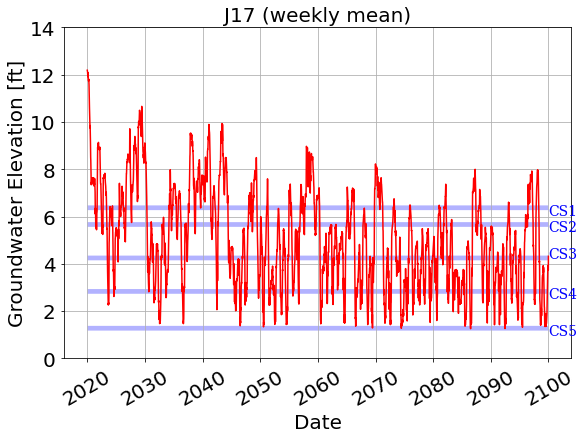

In [22]:
#-------------------------------------------------------------------------------------------------------------
# plot groundwater elevation at J-17
#-------------------------------------------------------------------------------------------------------------
cfs_to_m3  = 0.028316847
fnt_size      = 20
leg_loc       = 2
Station       = 'J17 (weekly mean)'
label         = 'J17'
y_ax_label    =  "Groundwater Elevation [ft]"
y_min         = 0
y_max         = 14 
num_cs        = 5   # number of critical stages 
cs1           = 225 * cfs_to_m3      # 660 # ft
cs2           = 200 * cfs_to_m3      # 650 # ft 
cs3           = 150 * cfs_to_m3      # 640 # ft
cs4           = 100 * cfs_to_m3      # 630 # ft
cs5           = 45 * cfs_to_m3      # 625 # ft
cs_line_thick = 0.1
legend_loc    = 2

plot_with_critical_stage(Station, df_SpringFlow, 'SF$[m^3/s]$', fnt_size, y_ax_label, y_min, y_max, label, num_cs, cs1, \
                         cs2, cs3, cs4, cs5, cs_line_thick, legend_loc, df_SpringFlow.Date[len(df_SpringFlow)-1])

In [23]:
#------------------------------------------------------------------------------------------------------
# - genarate the begining and end of decades as a list
#------------------------------------------------------------------------------------------------------

fmt                 =  "%Y-%m-%d"
frequency_start     = '10AS'
frequency_end       = '10A'

def date_list_generator(date_begin, num_per, frequency, fmt):
    date_list = []
    dates_raw = (pd.date_range(start = date_begin, periods = num_per, freq = frequency))
    date_list =  dates_raw.strftime(fmt).to_list()
    return date_list


In [24]:
start_date_list = []
date_start = '01-01-2020'
no_of_periods = 8
start_date_list = date_list_generator(date_start, no_of_periods, frequency_start, fmt) 
print(start_date_list)

end_data_list = []
date_start = '12-31-2029'
end_data_list = date_list_generator(date_start, no_of_periods, frequency_end, fmt) 
print(end_data_list)

#time_period_list = ['2020-2030', '2030-2040', '2040-2050', '2050-2060', '2060-2070' , '2070-2080', '2080-2090', '2090-2100'] 
time_period_list = ['1', '2', '3', '4', '5' , '6', '7', '8']
#print(time_period_list)

['2020-01-01', '2030-01-01', '2040-01-01', '2050-01-01', '2060-01-01', '2070-01-01', '2080-01-01', '2090-01-01']
['2029-12-31', '2039-12-31', '2049-12-31', '2059-12-31', '2069-12-31', '2079-12-31', '2089-12-31', '2099-12-31']


In [27]:
CS_dataframe = []
CS           = np.array([0, 1, 2, 3, 4, 5])
CS_dataframe = pd.DataFrame({'CS' : CS}) 
CS_dataframe

#------------------------------------------------------------------------------------------------------------------
# function that calculates % of unmet critical stages
#------------------------------------------------------------------------------------------------------------------

def CS_per_calculator (df, var, time_start, time_end, time_period, CS1, CS2, CS3, CS4, CS5 ): 
    
    date_int       = (df.Date > time_start) & (df.Date < time_end) 
    df_temp        = []
    df_temp        = df[date_int]
    df_temp.reset_index(drop = True, inplace = True)
    len_data       = len(df_temp)
    #print(len_data)
    
    condition      = df[var] >= CS1 
    Percent_no_CS  = (df.Date[date_int & condition].count() ) / len_data
    Percent_no_CS

    condition      = (df[var] < CS1) & (df[var] >= CS2)
    Percent_CS1    = (df.Date[date_int & condition].count() ) / len_data
    Percent_CS1    
    
    condition      = (df[var] < CS2) & (df[var] >= CS3)
    Percent_CS2    = (df.Date[date_int & condition].count() ) / len_data
    Percent_CS2
    
    condition      = (df[var] < CS3) & (df[var] >= CS4)
    Percent_CS3    = (df.Date[date_int & condition].count() ) / len_data
    Percent_CS3
    
    condition      = (df[var] < CS4) & (df[var] >= CS5)
    Percent_CS4    = (df.Date[date_int & condition].count() ) / len_data
    Percent_CS4
    
    condition      = (df[var] < CS5) 
    Percent_CS5    = (df.Date[date_int & condition].count() ) / len_data
    Percent_CS5
       
    per_CSs = np.array([Percent_no_CS,  Percent_CS1, Percent_CS2, Percent_CS3, Percent_CS4, Percent_CS5])
    CS_dataframe[time_period]= pd.Series(per_CSs)
    sum_col = CS_dataframe[time_period].sum()
   
    # make sure that sums up to 1.0
    print('time period :', time_period, ' sum of CS:', sum_col)   
    
    return CS_dataframe

In [29]:
for i in range(len(start_date_list)):
    time_start  = start_date_list[i]
    time_end    = end_data_list[i]
    time_period = time_period_list[i]
    df = CS_per_calculator (df_SpringFlow, 'SF$[m^3/s]$', time_start, time_end, time_period, cs1, cs2, cs3, cs4, cs5) 
      
df_SF_barblot = []
df_SF_barblot = df.copy()



time period : 1  sum of CS: 1.0
time period : 2  sum of CS: 1.0
time period : 3  sum of CS: 1.0
time period : 4  sum of CS: 1.0
time period : 5  sum of CS: 1.0
time period : 6  sum of CS: 1.0
time period : 7  sum of CS: 1.0
time period : 8  sum of CS: 1.0


In [30]:
#----------------------------------------------------------------------------------------------------------------------
# bar plot subroutine
#----------------------------------------------------------------------------------------------------------------------

from matplotlib import rc

#----------------------------------------------------------------------------------------------------------------------
# bar plot subroutine
#----------------------------------------------------------------------------------------------------------------------
def bar_plot_CS(df, title):

    fig = plt.figure()
    fig.set_size_inches(12.5, 8.5)    
    fnt_size = 22.5 
    
    # y-axis in bold
    rc('font', weight='normal')
 
    # Values of each group
    bars1 = list(df.iloc[0,1:])
    bars2 = list(df.iloc[1,1:])
    bars3 = list(df.iloc[2,1:])
    bars4 = list(df.iloc[3,1:])
    bars5 = list(df.iloc[4,1:])
    bars6 = list(df.iloc[5,1:])
    

    # Heights of bars(i) + bars(i+1)
    bars   = np.add(bars1, bars2).tolist()
    bars12 = np.add(bars1, bars2).tolist()
    bars23 = np.add(bars12, bars3).tolist()
    bars34 = np.add(bars23, bars4).tolist()
    bars45 = np.add(bars34, bars5).tolist()

    # The position of the bars on the x-axis
    r = [0,1,2,3,4, 5, 6, 7]
 
    # Names of group and bar width
    names = df.columns[1:]
    barWidth = 1


    edgecolour = 'black'
    # Create blue bars
    plt.bar(r, bars1, color='seashell', edgecolor=edgecolour, width=barWidth, label='No restriction')
    # Create green bars
    plt.bar(r, bars2, bottom=bars1, color='#f3ae85', edgecolor=edgecolour, width=barWidth, label='Critical Stage I')
    # Create khaki bars 
    plt.bar(r, bars3, bottom=bars12, color='#f17e52', edgecolor=edgecolour, width=barWidth, label='Critical Stage II')
    # Create coral bars
    plt.bar(r, bars4, bottom=bars23, color='#dc5328', edgecolor=edgecolour, width=barWidth, label='Critical Stage III')
    # Create crimson bars (top)
    plt.bar(r, bars5, bottom=bars34, color='b63609', edgecolor=edgecolour, width=barWidth, label='Critical Stage IV')
    # Create crimson bars (top)
    plt.bar(r, bars6, bottom=bars45, color='#420D09', edgecolor=edgecolour, width=barWidth, label='Critical Stage V')
 
    # Custom X axis
    plt.xticks(r, names, rotation = 0, fontsize = fnt_size)
    plt.xlabel("Future Decades",  fontsize = fnt_size)

    plt.ylabel('Fractional Occurrences', fontsize = fnt_size)
    plt.yticks(fontsize = fnt_size)
    #plt.title(title, fontsize = fnt_size)

    #plt.legend(loc=(0.64, 0.03), prop={'size': fnt_size-2})
    legend = plt.legend(bbox_to_anchor=(0., 1.01, 1., 0.), handletextpad=0.5,
                    loc='lower left', ncol=3, mode="expand", borderaxespad=0,
                    numpoints=1, handlelength=1.5, fontsize = fnt_size, frameon=True)
    legend.get_frame().set_linewidth('5')


    fig.savefig(title + '.jpeg', format='jpg', dpi=300, bbox_inches = 'tight')
    
    # Show graphic
    plt.show()


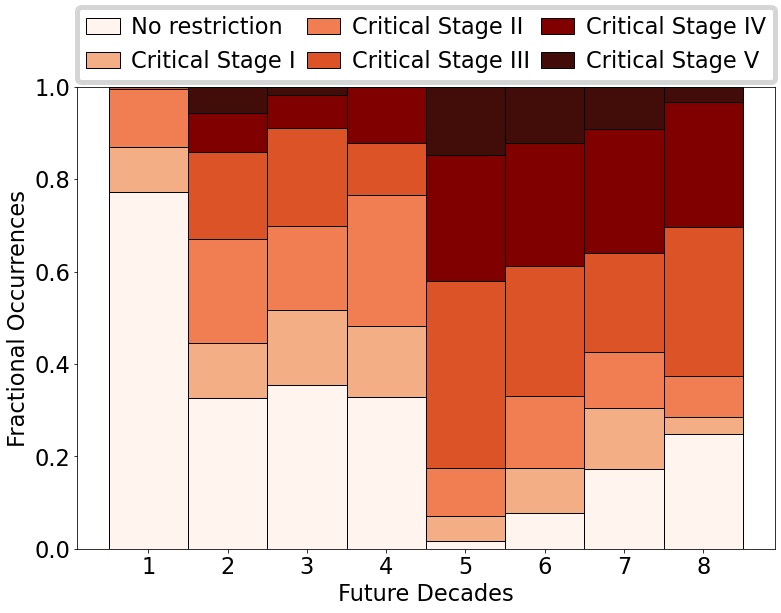

In [38]:
#----------------------------------------------------------------------------------------------------------------------
# bar plot for J17
#----------------------------------------------------------------------------------------------------------------------
fig_title = base_dir+base_folder+'/SF_barplot_gr'
bar_plot_CS(df_SF_barblot, fig_title)



In [129]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

#df_SpringFlow_data_reduced.index = df_SpringFlow_data_reduced['Date']
#df_SpringFlow_data_reduced = df_SpringFlow_data_reduced.drop(columns = 'Date')
df_play =df_SpringFlow_data_reduced.copy()

In [130]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
df_play = df_play.set_index('Date',drop=True)

In [131]:
df_SpringFlow_data_reduced

,Date,SF$[m^3/s]$
0,2020-01-05,13.237082
1,2020-01-12,13.625717
2,2020-01-19,12.449193
3,2020-01-26,12.285039
4,2020-02-02,12.343537
...,...,...
4169,2099-11-29,5.537324
4170,2099-12-06,5.714444
4171,2099-12-13,5.570041
4172,2099-12-20,5.446984


/home/c0d3b23ak32/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Date', ylabel='SF$[m^3/s]$'>

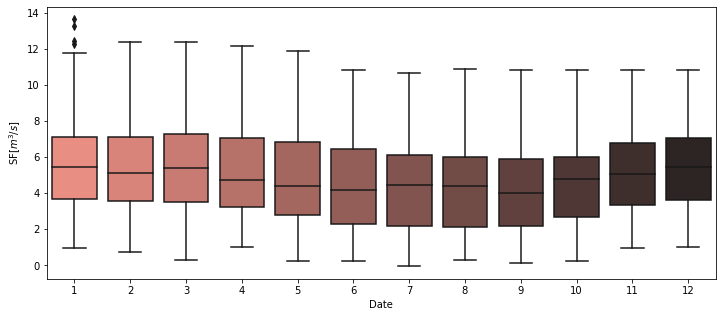

In [132]:


fig, ax = plt.subplots(figsize=(12,5))
seaborn.boxplot(df_play.index.month,
                df_play['SF$[m^3/s]$'], 
                palette = "dark:salmon_r",ax=ax)


<AxesSubplot:xlabel='Date'>

<Figure size 1296x864 with 0 Axes>

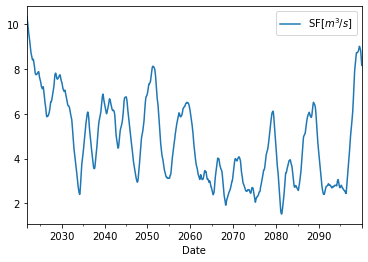

In [133]:
plt.figure(figsize=(18,12))
df_play.rolling(100).mean().dropna().plot()


 All libraries, tools, and functions have been succesfully uploaded  
Data length             : 4174
Number missing data     : 0
% missing data          : 0.0
Data length             : 4174
Number missing data     : 0
% missing data          : 0.0
['2020-01-01', '2030-01-01', '2040-01-01', '2050-01-01', '2060-01-01', '2070-01-01', '2080-01-01', '2090-01-01']
['2029-12-31', '2039-12-31', '2049-12-31', '2059-12-31', '2069-12-31', '2079-12-31', '2089-12-31', '2099-12-31']
time period : 1  sum of CS: 1.0
time period : 2  sum of CS: 1.0000000000000002
time period : 3  sum of CS: 1.0
time period : 4  sum of CS: 1.0
time period : 5  sum of CS: 0.9999999999999999
time period : 6  sum of CS: 0.9999999999999999
time period : 7  sum of CS: 1.0
time period : 8  sum of CS: 1.0


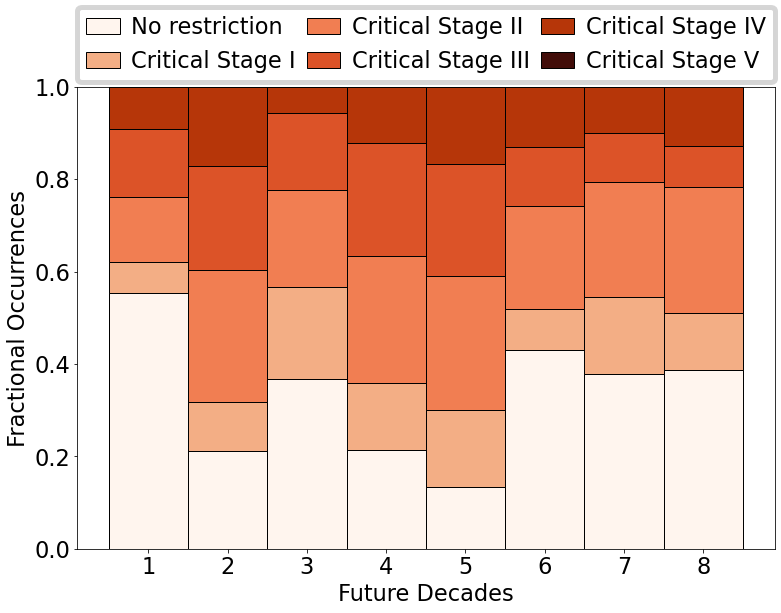

/home/c0d3b23ak32/Desktop/XAI/Springs/Comal/Catboost_untuned/RCP45
Data length             : 4174
Number missing data     : 0
% missing data          : 0.0
Data length             : 4174
Number missing data     : 0
% missing data          : 0.0
['2020-01-01', '2030-01-01', '2040-01-01', '2050-01-01', '2060-01-01', '2070-01-01', '2080-01-01', '2090-01-01']
['2029-12-31', '2039-12-31', '2049-12-31', '2059-12-31', '2069-12-31', '2079-12-31', '2089-12-31', '2099-12-31']
time period : 1  sum of CS: 1.0
time period : 2  sum of CS: 1.0
time period : 3  sum of CS: 1.0
time period : 4  sum of CS: 1.0
time period : 5  sum of CS: 1.0
time period : 6  sum of CS: 1.0
time period : 7  sum of CS: 1.0
time period : 8  sum of CS: 1.0


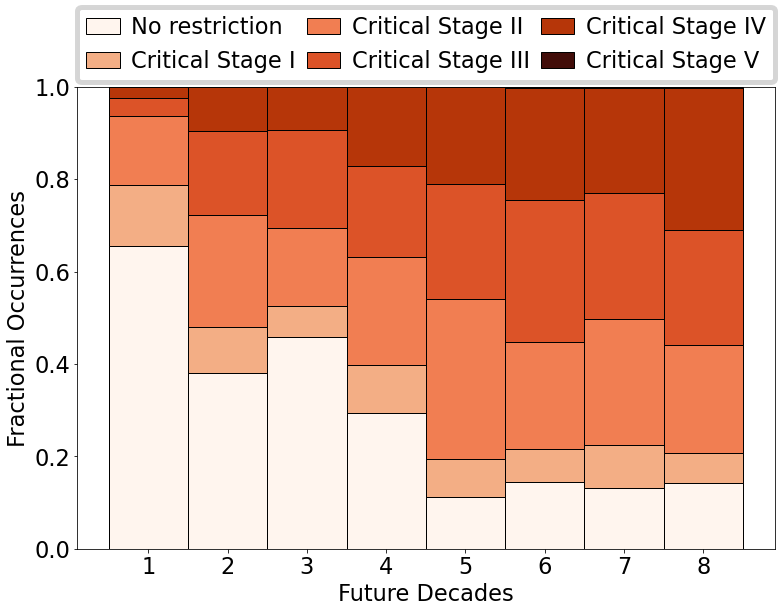

/home/c0d3b23ak32/Desktop/XAI/Springs/Comal/Catboost_untuned/RCP85


<Figure size 432x288 with 0 Axes>

In [31]:
%run -i critical_funct.py


